<a href="https://colab.research.google.com/github/mortgad/DLVR/blob/main/Regression_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to google

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# save_model_path = '/content/drive/MyDrive/DL for VR/Project/Models' # Thomas
#save_model_path = '/content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/' # Morten
save_model_path = '/content/drive/MyDrive/Visual reg' # Mads


Mounted at /content/drive


In [3]:
!git clone https://github.com/mortgad/DLVR.git
%cd DLVR

Cloning into 'DLVR'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (243/243), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 385 (delta 142), reused 163 (delta 95), pack-reused 142 (from 1)
Receiving objects: 100% (385/385), 54.89 MiB | 18.16 MiB/s, done.
Resolving deltas: 100% (204/204), done.
/content/DLVR


In [4]:
from utils.utkface import load_utkface
load_utkface()

from utils.utkface import preprocess_utkface
df_utkface, df_utkface_raw = preprocess_utkface()

Extracted part3.tar.gz
Extracted part2.tar.gz
Extracted part1.tar.gz
Deleted: /content/extracted/part3/55_0_0_20170116232725357jpg
Deleted: /content/extracted/part3/44_1_4_20170116235150272.pg
Deleted: /content/extracted/part3/.DS_Store
Deleted: /content/extracted/part1/61_1_20170109142408075.jpg
Deleted: /content/extracted/part1/61_3_20170109150557335.jpg
Deleted: /content/extracted/part2/53__0_20170116184028385.jpg
Deleted: /content/extracted/part2/39_1_20170116174525125.jpg
Deleted: /content/extracted/part3/24_0_1_20170116220224657 .jpg
Processing from: /content/extracted/part1
Processing from: /content/extracted/part2
Processing from: /content/extracted/part3


# Get data for modelling


In [5]:
df_utkface_raw.head()

,file,age_raw,gender_code,race_code,age,age_code,gender,race
0,/content/extracted/part1/39_0_0_20170104204646...,39,0,0,30-39,4,Male,White
1,/content/extracted/part1/1_1_4_201612212029128...,1,1,4,0-2,0,Female,Others
2,/content/extracted/part1/26_0_0_20170103181004...,26,0,0,20-29,3,Male,White
3,/content/extracted/part1/5_1_0_201701091913386...,5,1,0,3-9,1,Female,White
4,/content/extracted/part1/33_1_0_20170111182452...,33,1,0,30-39,4,Female,White


In [16]:
# Drop not needed colums:
df = df_utkface_raw[['age_raw','gender_code','race_code','file']]

df = df[df['age_raw']<=100]

df.rename(columns={'age_raw': 'age_code'}, inplace=True)
#df['age_code'] = df['age_code'].astype(float)
# df.rename(columns={'gender': 'gender_code'}, inplace=True)
# df.rename(columns={'race': 'race_code'}, inplace=True)

In [18]:
from utils.preprocessing import create_lists

images, ages, races, genders = create_lists(df)
print(f"Loaded {len(images)} images.")

# Number of classes for target variable
num_classes_age = len(set(ages))
num_classes_gender = len(set(genders))
num_classes_ethnicity = len(set(races))
print(f"Number of age classes: {num_classes_age}")
print(f"Number of gender classes: {num_classes_gender}")
print(f"Number of ethnicity classes: {num_classes_ethnicity}")

Loaded 24079 images.
Number of age classes: 97
Number of gender classes: 2
Number of ethnicity classes: 5


In [24]:
from sklearn.model_selection import train_test_split
from keras.applications.resnet_v2 import preprocess_input

images_preprocessed = preprocess_input(images)

# Split into train (80%) and temp (20%)
X_train, X_temp, y_train_age, y_temp_age, y_train_races, y_temp_races, y_train_gender, y_temp_gender = train_test_split(images_preprocessed, ages, races, genders, test_size=0.20, random_state=42, stratify=ages)

# Split temp into validation (75% of temp, which is 15% of original data) and test (25% of temp, which is 5% of original data)
X_val, X_test, y_val_age, y_test_age, y_val_races, y_test_races, y_val_gender, y_test_gender = train_test_split(X_temp, y_temp_age, y_temp_races, y_temp_gender, test_size=0.25, random_state=42)


print(f"Training set: {X_train.shape}, Training labels: {y_train_age.shape}")
print(f"Age validation set: {X_val.shape}, Age validation labels: {y_val_age.shape}")
print(f"Age test set: {X_test.shape}, Age test labels: {y_test_age.shape}")
print(f"Race validation labels: {y_val_races.shape}")
print(f"Race test labels: {y_test_races.shape}")
print(f"Gender validation labels: {y_val_gender.shape}")
print(f"Gender test labels: {y_test_gender.shape}")

Training set: (19263, 224, 224, 3), Training labels: (19263,)
Age validation set: (3612, 224, 224, 3), Age validation labels: (3612,)
Age test set: (1204, 224, 224, 3), Age test labels: (1204,)
Race validation labels: (3612,)
Race test labels: (1204,)
Gender validation labels: (3612,)
Gender test labels: (1204,)


# Training baseline model

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow import keras

# Now proceed with the ResNet50V2 model using the preprocessed images
conv_base = ResNet50V2(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

print("Conv base, training, and validation sets have been created...")

# Create the new model using ResNet50V2 as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
from tensorflow.keras import layers

x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)  # Dropout with a 50% rate

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Dropout with a 40% rate

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(64, activation='relu')(x)

# Adjust the output layer for age prediction
outputs = layers.Dense(1, activation='linear')(x)  # Single neuron for numeric output

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


94668760/94668760 [==============================] - 0s 0us/step
Conv base, training, and validation sets have been created...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   


In [ ]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1.5e-4)
model.compile(loss="mean_squared_error",  # Use MSE or MAE for regression
              optimizer=optimizer,
              metrics=["mae"])  # Optionally use MAE as a metric

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = '/content/drive/MyDrive/Visual reg' + "/"
model_name = 'resnet50v2_model_baseline.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_mae',  # Monitor MAE for regression
                             verbose=1,
                             save_best_only=True,
                             mode='min')  # For MAE, lower is better

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/20
602/602 [==============================] - ETA: 0s - loss: 686.0565 - mae: 20.6587
Epoch 1: val_mae improved from inf to 12.23808, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_baseline.keras
602/602 [==============================] - 286s 469ms/step - loss: 686.0565 - mae: 20.6587 - val_loss: 242.5660 - val_mae: 12.2381
Epoch 2/20
602/602 [==============================] - ETA: 0s - loss: 191.4489 - mae: 10.4950
Epoch 2: val_mae improved from 12.23808 to 8.80968, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_baseline.keras
602/602 [==============================] - 276s 458ms/step - loss: 191.4489 - mae: 10.4950 - val_loss: 151.0961 - val_mae: 8.8097
Epoch 3/20
602/602 [==============================] - ETA: 0s - loss: 138.5741 - mae: 8.6830
Epoch 3: val_mae improved from 8.80968 to 8.42727, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_baseline.keras
602/602 [==============================] - 277s 461ms/step - 

Best Training MAE: 5.0092
Best Validation MAE: 7.6974
Best Training Loss: 44.8473
Best Validation Loss: 125.4419


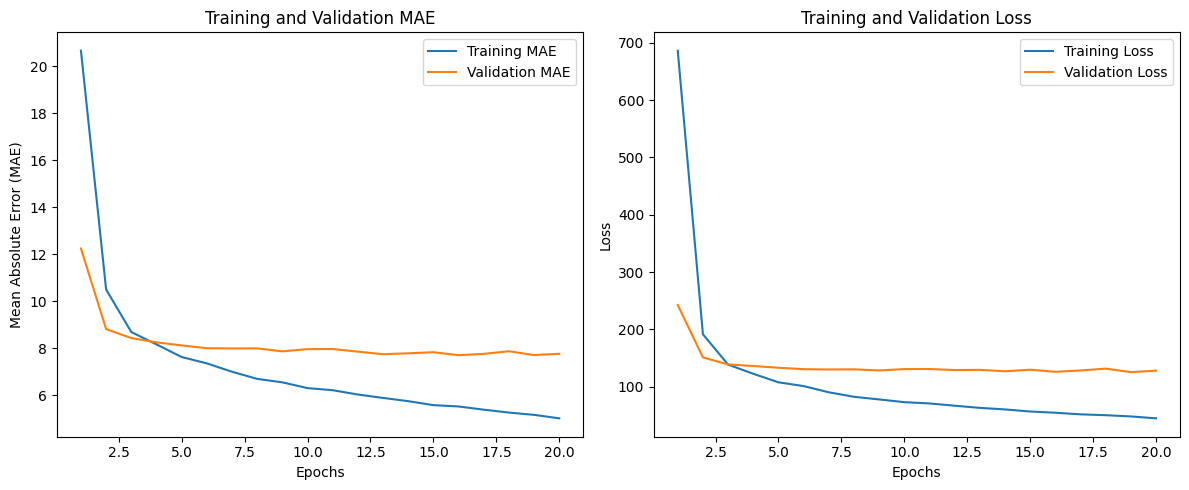

In [ ]:
#from utils.preprocessing import evaluate_and_plot

# Evaluate and plot the model
evaluate_and_plot(resnet_history)

In [25]:
def evaluate_and_plot(history, mae_key='mae', val_mae_key='val_mae', loss_key='loss', val_loss_key='val_loss'):
    import matplotlib.pyplot as plt
    # Get the MAE and loss data from the history object
    mae = history.history[mae_key]
    val_mae = history.history[val_mae_key]
    loss = history.history[loss_key]
    val_loss = history.history[val_loss_key]
    epochs = range(1, len(mae) + 1)

    # Find the best MAE and loss values
    best_mae = min(mae)  # Lower MAE is better
    best_val_mae = min(val_mae)
    best_loss = min(loss)
    best_val_loss = min(val_loss)

    # Print the best values
    print(f"Best Training MAE: {best_mae:.4f}")
    print(f"Best Validation MAE: {best_val_mae:.4f}")
    print(f"Best Training Loss: {best_loss:.4f}")
    print(f"Best Validation Loss: {best_val_loss:.4f}")

    # Plotting MAE
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, mae, label='Training MAE')
    plt.plot(epochs, val_mae, label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()


# Training Multitask model


In [30]:
from keras.applications import ResNet50V2
import keras
from keras import layers, models
import numpy as np
input_shape = images[0].shape

# Load the ResNet50V2 model
conv_base = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
)
conv_base.trainable = True

# Freeze all BatchNormalization layers
for layer in conv_base.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

# Create the new model using ResNet50V2 as the base
inputs = keras.Input(input_shape)
# x = keras.applications.resnet_v2.preprocess_input(inputs) # <----- images er allerede preprocessed
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
age = layers.Dense(512, activation='relu')(x)
age = layers.BatchNormalization()(age)
age = layers.Dropout(0.3)(age)
age = layers.Dense(256, activation='relu')(age)
age = layers.BatchNormalization()(age)
age = layers.Dense(128, activation='relu')(age)
age = layers.BatchNormalization()(age)
age = layers.Dropout(0.2)(age)
age = layers.Dense(64, activation='relu')(age)
age = layers.Dense(1, activation='linear', name='age_output')(age)
gender = layers.Dense(512, activation='relu')(x)
gender = layers.BatchNormalization()(gender)
gender = layers.Dropout(0.3)(gender)
gender = layers.Dense(256, activation='relu')(gender)
gender = layers.BatchNormalization()(gender)
gender = layers.Dropout(0.2)(gender)
gender = layers.Dense(128, activation='relu')(gender)
gender = layers.BatchNormalization()(gender)
gender = layers.Dense(64, activation='relu')(gender)
gender = layers.Dense(num_classes_gender, activation="softmax", name='gender_output')(gender)
#race = layers.Dense(512, activation='relu')(x)
#race = layers.BatchNormalization()(race)
#race = layers.Dropout(0.3)(race)
#race = layers.Dense(256, activation='relu')(race)
#race = layers.BatchNormalization()(race)
#race = layers.Dropout(0.2)(race)
#race = layers.Dense(128, activation='relu')(race)
#race = layers.BatchNormalization()(race)
#race = layers.Dense(64, activation='relu')(race)
#race = layers.Dense(num_classes_ethnicity, activation="softmax", name='race_output')(race)
multitask_model = keras.Model(inputs=inputs, outputs=[age, gender]) # Race deleted
multitask_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50v2 (Functional)     (None, 7, 7, 2048)           2356480   ['input_4[0][0]']             
                                                          0                                       
                                                                                                  
 global_average_pooling2d_1  (None, 2048)                 0         ['resnet50v2[0][0]']          
  (GlobalAveragePooling2D)                                                                        
                                                                                            

In [31]:
# Define num_classes_gender and num_classes_ethnicity
#num_classes_gender = 2  # Adjust based on your dataset
#num_classes_ethnicity = 5  # Adjust based on your dataset

optimizer = keras.optimizers.Adam(learning_rate=1.5e-4)

multitask_model.compile(
    optimizer=optimizer,
    loss={
        "age_output": "mean_squared_error",
        "gender_output": "sparse_categorical_crossentropy"#,"race_output": "sparse_categorical_crossentropy"
    },
    #metrics={
    #    "age_output": ["mae"],
    #    "gender_output": ["accuracy"],
    #    "race_output": ["accuracy"]
    #}
    metrics = [['mae'], ['accuracy']]#, ['accuracy']]
)

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = save_model_path
model_name = 'resnet50v2_model_multitask.keras'

# Define ModelCheckpoint callback to monitor gender or race accuracy, or age mae
multitask_checkpoint = ModelCheckpoint(
    file_path + model_name,
    monitor='val_age_output_mae',  # Adjust as needed
    verbose=1,
    save_best_only=True,
    mode='max'
)


In [ ]:
# Train the model
multitask_history = multitask_model.fit(
    X_train,
    [y_train_age, y_train_gender],  # Delted = , y_train_races
    epochs=20,
    batch_size=32,
    validation_data=(X_val, [y_val_age, y_val_gender]), # Deleted = , y_val_races
    callbacks=[multitask_checkpoint]
)

# Data augmentation


In [35]:
# Define data augmentation:
from tensorflow import keras
from tensorflow.keras import layers


data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomContrast(0.1)
])

In [36]:
from tensorflow.keras import layers
from tensorflow import keras

# Now proceed with the ResNet50V2 model using the preprocessed images
conv_base = ResNet50V2(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

# Create the new model using ResNet50V2 as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))

x = data_augmentation(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)  # Dropout with a 50% rate

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Dropout with a 40% rate

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(64, activation='relu')(x)

# Adjust the output layer for age prediction
outputs = layers.Dense(1, activation='linear')(x)  # Single neuron for numeric output

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_15 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_20 (Dense)            (None, 512)               1049

In [37]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1.5e-4)
model.compile(loss="mean_squared_error",  # Use MSE or MAE for regression
              optimizer=optimizer,
              metrics=["mae"])  # Optionally use MAE as a metric

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = '/content/drive/MyDrive/Visual reg' + "/"
model_name = 'resnet50v2_model_dropout.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_mae',  # Monitor MAE for regression
                             verbose=1,
                             save_best_only=True,
                             mode='min')  # For MAE, lower is better

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/20
602/602 [==============================] - ETA: 0s - loss: 743.5830 - mae: 21.3585
Epoch 1: val_mae improved from inf to 10.48877, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_dropout.keras
602/602 [==============================] - 283s 463ms/step - loss: 743.5830 - mae: 21.3585 - val_loss: 205.0775 - val_mae: 10.4888
Epoch 2/20
602/602 [==============================] - ETA: 0s - loss: 212.8786 - mae: 10.8947
Epoch 2: val_mae improved from 10.48877 to 9.49402, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_dropout.keras
602/602 [==============================] - 275s 457ms/step - loss: 212.8786 - mae: 10.8947 - val_loss: 171.6758 - val_mae: 9.4940
Epoch 3/20
602/602 [==============================] - ETA: 0s - loss: 194.2006 - mae: 10.2951
Epoch 3: val_mae improved from 9.49402 to 9.15173, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_dropout.keras
602/602 [==============================] - 276s 459ms/step - lo

Best Training MAE: 8.2607
Best Validation MAE: 8.6532
Best Training Loss: 128.2061
Best Validation Loss: 155.6714


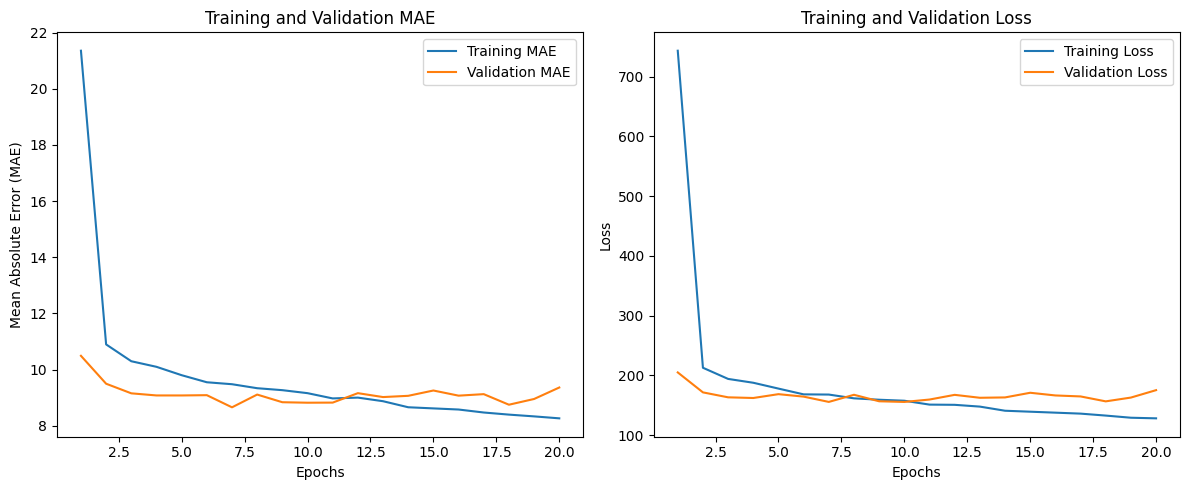

In [38]:
evaluate_and_plot(resnet_history)